In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import lmfit

In [2]:
df = pd.read_csv('../TestData.csv')
df_phase = pd.read_csv('../PhaseData.csv')
data = df.to_numpy()
phase_data = df_phase.to_numpy()

print(df.columns)
print(df_phase.columns)

Index(['Vpp (V)', 'Frequency (Hz)', 'Displacement (Microns)',
       'Uncertainty (Microns)'],
      dtype='object')
Index(['Frequency (Hz)', 'Phase (radians)', 'Uncertainty (radians)'], dtype='object')


In [3]:
data2v = data[:-13]
vpp2 = data2v[:, 0]
freqs2 = data2v[:, 1]
displ2 = data2v[:, 2]
displ2_sigma = data2v[:, 3]

data1v = data[-13:]
vpp1 = data1v[:, 0]
freqs1 = data1v[:, 1]
displ1 = data1v[:, 2]

freqs_phase = phase_data[:, 0]
phases = phase_data[:, 1]
phase_sigma = phase_data[:, 2]

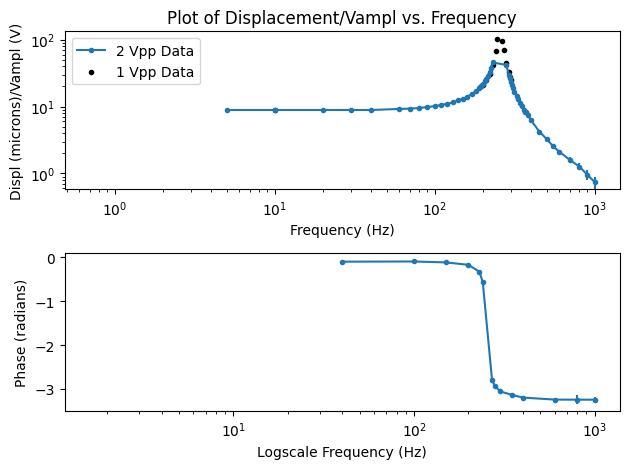

In [13]:
vampl1 = vpp1/2
vampl2 = vpp2/2

fig, ax = plt.subplots(2)
ax[0].plot(freqs2, displ2/vampl2, marker='.', label="2 Vpp Data")
ax[0].scatter(freqs1, displ1/vampl1, marker='.', label="1 Vpp Data", color='black')
ax[0].set_title("Plot of Displacement/Vampl vs. Frequency")
ax[0].legend()
ax[0].loglog()
ax[0].set_ylabel("Displ (microns)/Vampl (V)")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].errorbar(freqs2, displ2/vampl2, yerr=displ2_sigma, fmt='none')

ax[1].plot(freqs_phase, phases, marker='.')
ax[1].set_xscale('log')
ax[1].set_xlabel("Logscale Frequency (Hz)")
ax[1].set_ylabel("Phase (radians)")
ax[1].errorbar(freqs_phase, phases, yerr=phase_sigma, fmt='none')
plt.tight_layout()

$$
A = \frac{k f_0^2}{\sqrt{(f_0^2 - f^2)^2 + \frac{f_0^2}{Q^2}f^2}}
$$

In [7]:
def A(f, f0, Q, k):
    return (k * f0**2) / np.sqrt((f0**2 - f**2)**2 + f0**2*f**2/Q**2)

Add constant $c$ to account for phase offset from data between 40-1kHz: 


$$
\phi = \arctan \left( \frac{\frac{f_0}{Q} f}{f^2 - f_0^2} \right) + c
$$

In [8]:
def phase(f_trunc, f0, Q, c):
    return np.arctan2(f0/Q*f_trunc, f_trunc**2 - f0**2) + c

In [9]:
params = lmfit.Parameters()
params.add_many(('f0', 255), ('Q', 30), ('k', 1), ('c', 0.1))

In [10]:
f_tot = np.append(freqs_phase, freqs2)
y_tot = np.append(phases, displ2/vampl2)

In [16]:
def combined_func(ftot, f0, Q, k, c):
    f_trunc  = ftot[:len(freqs_phase)]
    f = ftot[len(freqs_phase):]
    
    phase_val = phase(f_trunc, f0, Q, c)
    A_val = A(f, f0, Q, k)
    
    return np.append(phase_val, A_val)

In [12]:
model = lmfit.Model(combined_func, weights=np.append(1/phase_sigma, 1/displ2_sigma), scale_covar=False)
params = model.make_params(f0=255, Q=30, k=1, c=-0.1)
print(f'parameter names: {model.param_names}')
print(f'independent variables: {model.independent_vars}')

parameter names: ['f0', 'Q', 'k', 'c']
independent variables: ['ftot']


In [14]:
result = model.fit(y_tot, params, ftot=f_tot)

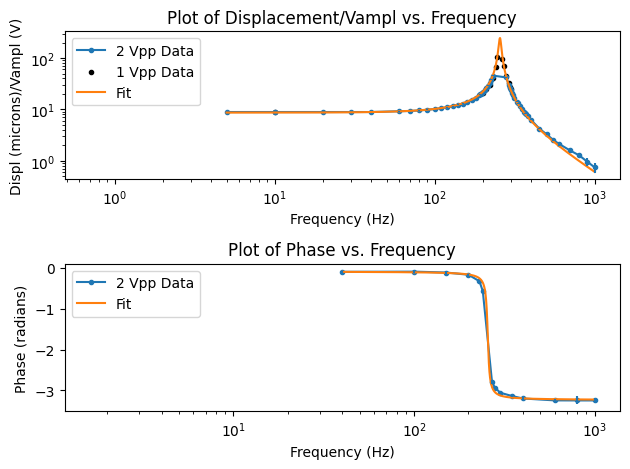

In [22]:
vampl1 = vpp1/2
vampl2 = vpp2/2

fig, ax = plt.subplots(2)
ax[0].plot(freqs2, displ2/vampl2, marker='.', label="2 Vpp Data")
ax[0].scatter(freqs1, displ1/vampl1, marker='.', label="1 Vpp Data", color='black')
freq_range = np.linspace(5, 1000, 1000)
ax[0].plot(
    freq_range,
    A(freq_range, result.params['f0'], result.params['Q'], result.params['k']),
    label="Fit",
)
ax[0].set_title("Plot of Displacement/Vampl vs. Frequency")
ax[0].legend()
ax[0].loglog()
ax[0].set_ylabel("Displ (microns)/Vampl (V)")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].errorbar(freqs2, displ2/vampl2, yerr=displ2_sigma, fmt='none')

ax[1].plot(freqs_phase, phases, marker='.', label="2 Vpp Data")
pfreq_range = np.linspace(40, 1000, 960)
ax[1].plot(
    pfreq_range,
    phase(pfreq_range, result.params['f0'], result.params['Q'], result.params['c']),
    label="Fit",
)
ax[1].set_xscale('log')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("Phase (radians)")
ax[1].legend()
ax[1].set_title("Plot of Phase vs. Frequency")
ax[1].errorbar(freqs_phase, phases, yerr=phase_sigma, fmt='none')
plt.tight_layout()

In [19]:
result

In [10]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
k,8.64730281,0.03474629,(0.40%),1.0,-inf,inf,True
f0,255.703286,0.09830820,(0.04%),250.0,-inf,inf,True
Q,30.5280698,8.05375565,(26.38%),1.0,-inf,inf,True
